## Mackenzie river runoff extension

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import netCDF4 as nc
from itertools import compress
import datetime as dt
from datetime import date
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import warnings
import matplotlib.animation as animation
from matplotlib import rc
warnings.filterwarnings('ignore')
import glob

%matplotlib inline

In [59]:
import gsw

#### Parameters:

In [2]:
# Domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799
isize = imax - imin
jsize = jmax - jmin

# Results folders:
folder_ref  = '/data/brogalla/run_storage/Mn-reference-202110/'
folder_glac = '/data/brogalla/run_storage/river-glacial-202112/'
folder_cont = '/data/brogalla/run_storage/river-continental-202112/'

# Color map:
N = 256
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(171/N, 1, N)
vals_cont[:, 1] = np.linspace(92/N, 1, N)
vals_cont[:, 2] = np.linspace(41/N, 1, N)
cont_cmap = ListedColormap(vals_cont).reversed()

vals_glac = np.ones((N, 4))
vals_glac[:, 0] = np.linspace(8/N, 1, N)
vals_glac[:, 1] = np.linspace(115/N, 1, N)
vals_glac[:, 2] = np.linspace(180/N, 1, N)
glac_cmap = ListedColormap(vals_glac).reversed()

vals_both = np.ones((N, 4))
vals_both[:, 0] = np.linspace(89/N, 1, N); 
vals_both[:, 1] = np.linspace(89/N, 1, N)
vals_both[:, 2] = np.linspace(89/N, 1, N)
both_cmap = ListedColormap(vals_both).reversed()

land_color = '#a9a7a2'

#### Load files:

In [3]:
# Meshmask:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
lon_ANHA12 = np.array(mesh.variables['nav_lon'])
lat_ANHA12 = np.array(mesh.variables['nav_lat'])
tmask      = np.array(mesh.variables['tmask'])
land_mask  = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 

tmask_full    = np.empty((12,50,isize,jsize))
tmask_full[:] = tmask[0,:,imin:imax,jmin:jmax]

# sub-domain:
mn_ref  = nc.Dataset('/data/brogalla/run_storage/Mn-reference-202110/ANHA12_ref-2002_20211012/ANHA12_EXH006_2002_monthly.nc',  'r')
lon_sub = np.array(mn_ref.variables['nav_lon'])
lat_sub = np.array(mn_ref.variables['nav_lat'])
depth   = np.array(mn_ref.variables['deptht'])

In [4]:
# Meshmasks
mask          = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask         = np.array(mask.variables['tmask'])
land_mask     = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 
tmask_full    = np.empty((12,50,isize,jsize))
tmask_full[:] = tmask[0,:,imin:imax,jmin:jmax]
lon_ANHA12    = np.array(mask.variables['nav_lon'])
lat_ANHA12    = np.array(mask.variables['nav_lat'])
e3t           = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e1t_base      = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base      = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
hdept         = np.array(mask.variables['hdept'])[0,imin:imax,jmin:jmax]

In [5]:
index_bottom = 17
depth_bottom = np.copy(hdept) # sum from surface to sea floor
depth_bottom[depth_bottom > depth[index_bottom]] = depth[index_bottom] # sum over depth from surface to index bottom
depth_bottom[depth_bottom == 0] = np.nan # where ocean depth is zero, replace depth with NaN

#### Functions:

Calculate the proportional contribution of glacial rivers to each grid cell:

$$ prop = \frac{Mn_{glacier}-Mn_{base}}{Mn_{base}} = \frac{Mn_{glacier}}{Mn_{base}} - 1 $$

In [6]:
def calculate_prop(dmn_riv_off, dmn_riv_on):
    # Input arguments:
    # - dmn_riv_on (t,z,y,x) --- concentration of dMn with riverine contribution on
    # - dmn_riv_off(t,z,y,x) --- concentration of dMn with rivers off
    
    diff_rivers = dmn_riv_on - dmn_riv_off
    
    # Contribution of rivers / total concentration (with rivers on):
    # should be an elementwise operation
    prop_river  = np.divide(diff_rivers, dmn_riv_off)*2*100 # multiply by 2 so that 100%
    
#     # weight by depth: 
#     depth_sum_cont = np.nansum(prop_river[0:index_bottom,:,:]*e3t[0:index_bottom,:,:], axis=0)
#     prop_surface   = depth_sum_cont/depth_bottom

#     prop_surface = np.nanmean(prop_river[0:17,:,:], axis=0)
    
    # Output:
    # - prop_river(t,z,y,x)  --- proportional contribution of river to observed [dMn]
    return prop_river
#     return prop_surface

# Mackenzie river analysis

Fichot et al. (2013): "A progressive switch from eastward to northwestward routing occurred between 2002 and 2011  and coincides with the rapid freshening of the Canada Basin." 

In [7]:
def load_5d_results(file_ref, file_cont):    
    base = nc.Dataset(file_ref)
    cont = nc.Dataset(file_cont)
    
    dmn_base = np.array(base.variables['dissolmn'])[0,:,:,:]
    dmn_cont = np.array(cont.variables['dissolmn'])[0,:,:,:]
    
    return dmn_base, dmn_cont

In [8]:
def load_wind_results(year, Mackenzie=False):
    folder = '/data/brogalla/ANHA12/atmospheric_forcing/'
    fileu  = f'u10_gdps_y{year}.nc'
    filev  = f'v10_gdps_y{year}.nc'
    
    uyear  = nc.Dataset(folder+fileu)
    vyear  = nc.Dataset(folder+filev)
    
    u_wind = np.array(uyear.variables['u_wind'])
    v_wind = np.array(vyear.variables['v_wind'])
    lons = np.array(uyear.variables['LON'])
    lons = [lon-360 if (lon > 180) else lon for lon in lons] 
    lats = np.array(uyear.variables['LAT'])
    
    if Mackenzie:
        # find subset indices for the Mackenzie river:
        i=0; n=0;
        for lat in lats:
            if (lat > 65) & (i==0):
                min_lat = n
                i+=1
            elif (lat < 78) & (i==1):
                max_lat = n
            n+=1

        i=0; n=0;
        for lon in lons:
            if (lon < -160) & (lon > -161) & (i==0):
                min_lon = n
                i+=1
            elif (lon < -100) & (lon > -101) & (i==1):
                max_lon = n
            n+=1    

        wind_lons = lons[min_lon:max_lon]
        wind_lats = lats[min_lat:max_lat]

        uwind = u_wind[:,min_lat:max_lat,min_lon:max_lon]
        vwind = v_wind[:,min_lat:max_lat,min_lon:max_lon]
        return uwind, vwind, wind_lons, wind_lats
    else:
        return u_wind, v_wind, lons, lats

In [23]:
def look_river_data(start_date, end_date):
    
    files_list_ref  = np.sort(glob.glob(f'/data/brogalla/run_storage/Mn-reference-202110/ANHA12_ref-{start_date.year}_20211012/'+\
                                        f'ANHA12_EXH006_5d_{start_date.year}0101_{start_date.year}1231_ptrc_T_*'))
    files_list_cont = np.sort(glob.glob(f'/data/brogalla/run_storage/river-continental-202112/ANHA12_continental-{start_date.year}'+\
                                        f'_20211130/ANHA12_EXH006_5d_{start_date.year}0101_{start_date.year}1231_ptrc_T_*'))
    
    files_ref_start = [dt.datetime.strptime(i[114:122], "%Y%m%d") for i in files_list_ref]
    files_ref_end   = [dt.datetime.strptime(i[123:131], "%Y%m%d") for i in files_list_ref]
    files_ref       = list(compress(files_list_ref, [V > start_date and V < end_date for V in files_ref_start]))

    files_cont_start = [dt.datetime.strptime(i[127:135], "%Y%m%d") for i in files_list_cont]
    files_cont_end   = [dt.datetime.strptime(i[136:144], "%Y%m%d") for i in files_list_cont]
    files_cont       = list(compress(files_list_cont, [V > start_date and V < end_date for V in files_cont_start]))
    
    continental_contribution=np.empty((len(files_ref),isize,jsize))

    for i in range(0,len(files_ref)):
        base, cont = load_5d_results(files_ref[i], files_cont[i])
        continental_contribution[i,:,:] = calculate_prop(base, cont) 
    
    return files_ref, files_cont, continental_contribution

In [45]:
def look_TS_data(start_date, end_date):

    files_list_ref  = np.sort(glob.glob(f'/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridT_y{start_date.year}m*'))
    
    files_ref_end   = [dt.datetime.strptime(i[45:56], "y%Ym%md%d") for i in files_list_ref]
    files_ref       = list(compress(files_list_ref, [V > start_date and V < end_date for V in files_ref_end]))

    T_profile=np.empty((len(files_ref),50,isize,jsize))
    S_profile=np.empty((len(files_ref),50,isize,jsize))

    for i in range(0,len(files_ref)):
        ref_file = nc.Dataset(files_ref[i])
        ref_temp = np.array(ref_file.variables['votemper'])[0,:,imin:imax,jmin:jmax]
        ref_sal  = np.array(ref_file.variables['vosaline'])[0,:,imin:imax,jmin:jmax]
        
        T_profile[i,:,:,:] = ref_temp
        S_profile[i,:,:,:] = ref_sal
    
    return files_ref, T_profile, S_profile

In [46]:
def look_wind_data(start_date, end_date):
    
    uwind, vwind, wind_lons, wind_lats = load_wind_results(start_date.year, Mackenzie=True)
    
    hourly_dates = [dt.datetime(start_date.year,1,1)+dt.timedelta(hours=i) for i in range(1,365*24+1)]

    # index of start date and end date within the hourly dates of the wind data:
    start_hindex = (start_date - dt.datetime(start_date.year,1,1)).days*24
    end_hindex   = (end_date - dt.datetime(start_date.year,1,1)).days*24

    # dates during which I look at tracer concentrations as well:
    overlap_dates = hourly_dates[start_hindex:end_hindex]
    overlap_uwind = uwind[start_hindex:end_hindex,:,:]
    overlap_vwind = vwind[start_hindex:end_hindex,:,:]
    
    return overlap_dates, overlap_uwind, overlap_vwind, wind_lons, wind_lats

In [47]:
#start_date and end_date are datetime objects
start_date_20093 = dt.datetime(2009,2,10) # from 2008-10-22 onwards the plume is set up to go towards the east
end_date_20093   = dt.datetime(2009,7,30)

# files_ref_20093, files_cont_20093, continental_contribution_20093  \
#                                                                 = look_river_data(start_date_20093, end_date_20093)
files_ref_20093, T_profile_20093, S_profile_20093  = look_TS_data(start_date_20093, end_date_20093)
overlap_dates_20093, overlap_uwind_20093, overlap_vwind_20093, \
                                           wind_lons, wind_lats = look_wind_data(start_date_20093, end_date_20093)

# ignore areas with less than 1% of continental river contribution to dMn
# continental_contribution_masked_20093 = np.ma.masked_where((continental_contribution_20093 < 0.01), \
#                                                             continental_contribution_20093)

In [33]:
files_ref_20093, files_cont_20093, continental_contribution_20093  \
                                                                = look_river_data(start_date_20093, end_date_20093)

Show "20090215-2090219" or "20090220-20090224" for eastward prevailing wind and "20090411-20090415" or "20090401-20090405" for westward.

In [16]:
def plot_5d_mackenzie(ax, fday, time, files_ref, overlap_dates, overlap_uwind, overlap_vwind, wind=False, lw=0, \
                     set_lw=False):

    proj2 = Basemap(projection='stere',lat_0 = 71, lon_0 = -135, resolution='i', width=1.5e6, height=1.0e6, ax=ax)
    
    x_land, y_land = proj2(lon_ANHA12, lat_ANHA12)
    proj2.drawcoastlines(color='#373736', linewidth=1.0)
    proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
    proj2.drawparallels(np.arange(int(60),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=6)
    proj2.drawmeridians(np.arange(int(-150),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=6)

    #--------------------- five day surface continental runoff field------------------------------
    x_model, y_model = proj2(lon_sub, lat_sub)

    cont_levels= [10,20,30]
    CS2  = proj2.pcolormesh(x_model, y_model, fday, cmap=cont_cmap, vmin=0, vmax=30)
    cont = proj2.contour(x_model, y_model, fday, levels=cont_levels, colors='#894920', linewidths=0.4, zorder=4)

    ax.set_title(f'{files_ref[time][114:118]}-{files_ref[time][118:120]}-{files_ref[time][120:122]} to ' + \
                 f'{files_ref[time][123:127]}-{files_ref[time][127:129]}-{files_ref[time][129:131]}', fontsize=6)

    #--------------------- wind stream plot ------------------------------------------------------
    if wind:
        startt = np.datetime64(dt.datetime.strptime(files_ref[time][114:122],  '%Y%m%d'))
        endt   = np.datetime64(dt.datetime.strptime(files_ref[time][123:131], '%Y%m%d'))
        
        time_ind = np.array(np.where((overlap_dates > startt) & (overlap_dates < endt)))[0]
        
        u_1h_wind = np.zeros(overlap_uwind[0,:,:].shape); v_1h_wind=np.zeros(overlap_vwind[0,:,:].shape);
        for t in time_ind:
            u_1h_wind = np.add(overlap_uwind[t,:,:], u_1h_wind)
            v_1h_wind = np.add(overlap_vwind[t,:,:], v_1h_wind)
            
        u_5d_wind = u_1h_wind/len(time_ind)
        v_5d_wind = v_1h_wind/len(time_ind)
        
        speed = np.sqrt(u_5d_wind**2 + v_5d_wind**2)
        
        wlons, wlats   = np.meshgrid(wind_lons, wind_lats)
        x_wind, y_wind = proj2(wlons, wlats)
    
        ax.quiver(x_wind[::2,::7], y_wind[::2,::7], u_5d_wind[::2,::7], v_5d_wind[::2,::7], \
                        color='k', headwidth=7, scale=100) # 100 m/s per plot width
        QV1 = ax.quiver([1.9e5], [3.0e5], [10],[0], color='k', headwidth=4, scale=100, zorder=6)
        ax.text(1.9e5, 3.4e5, r'10 $\frac{m}{s}$', fontsize=6, zorder=6)
        
    ax.fill_between(x_land[imax,:], y_land[imax,:], y_land[imax+200,:], color='#d8d8d6')

    proj2.drawmapscale(-147, 67.5, -140, 75, 400, barstyle='fancy', zorder=6, fontsize=6, linewidth=0.4)
    
    return lw, CS2, cont, QV1

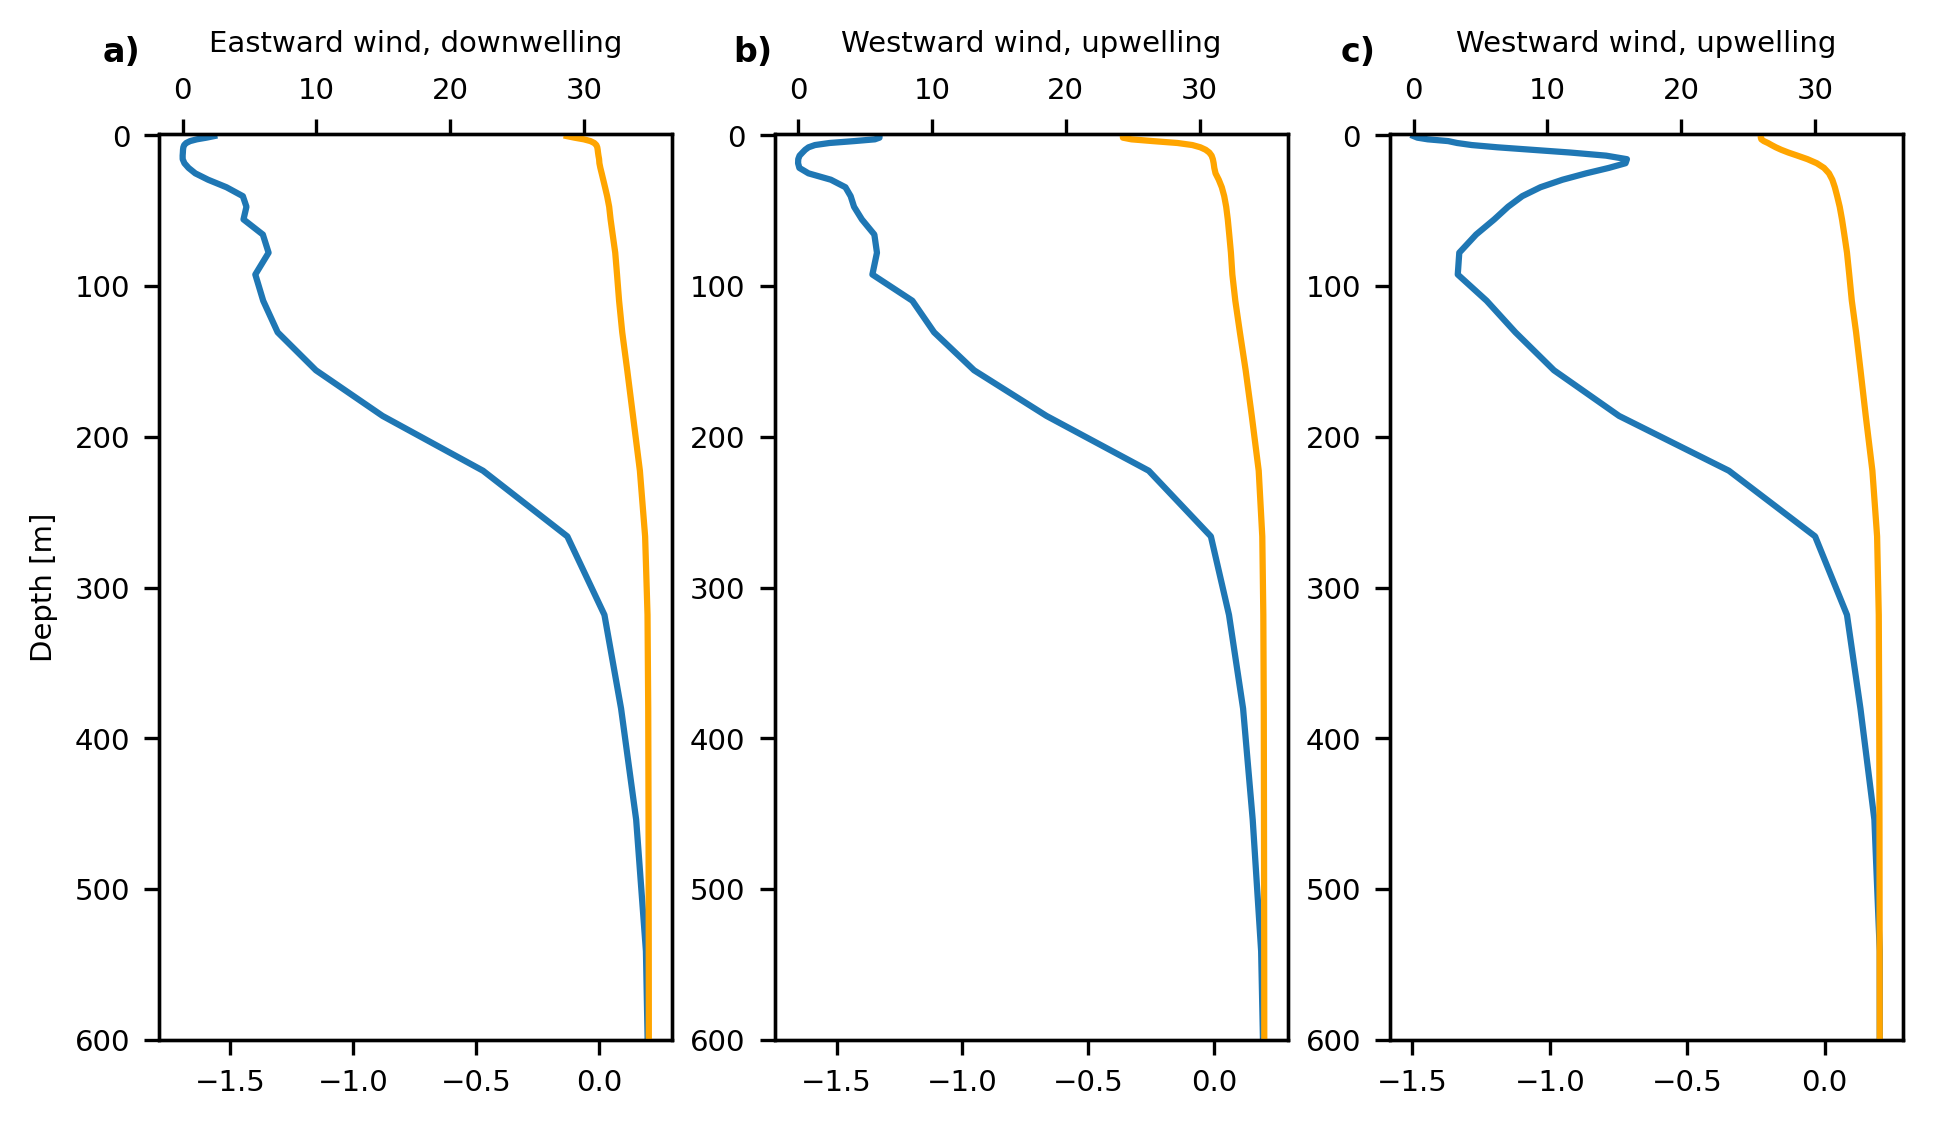

In [58]:
fig, ax = plt.subplots(1,3, figsize=(7.5,4), dpi=300)
# station coordinates:
istn = 650 #650
jstn = 301 #305

ax[0].set_ylabel('Depth [m]', fontsize=7)
for axis in ax.ravel():
    axis.invert_yaxis()
    axis.set_ylim(600,-1)
    axis.tick_params(axis='both', labelsize=7)
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top')

ax[0].plot(T_profile_20093[1,:,istn,jstn], depth)
ax[1].plot(T_profile_20093[11,:,istn,jstn], depth)
ax[2].plot(T_profile_20093[32,:,istn,jstn], depth)

ax1 = ax[0].twiny()
ax2 = ax[1].twiny()
ax3 = ax[2].twiny()
ax1.plot(S_profile_20093[1,:,istn,jstn], depth , c='orange')
ax2.plot(S_profile_20093[11,:,istn,jstn], depth, c='orange')
ax3.plot(S_profile_20093[32,:,istn,jstn], depth, c='orange')

for axis in [ax1, ax2, ax3]:
    axis.tick_params(axis='both', labelsize=7)

# Labels:
ax[0].set_title('Eastward wind, downwelling', fontsize=7)
# ax[0].set_xlim(0,2)
ax[1].set_title('Westward wind, upwelling', fontsize=7)
# ax[1].set_xlim(0,15)
ax[2].set_title('Westward wind, upwelling', fontsize=7)
# ax[2].set_xlim(0,15)
fig.text(0.10, 0.94, 'a)', fontsize=8, weight='bold');
fig.text(0.38, 0.94, 'b)', fontsize=8, weight='bold');
fig.text(0.65, 0.94, 'c)', fontsize=8, weight='bold');

In [60]:
density = gsw.density.sigma0(S_profile_20093, T_profile_20093)

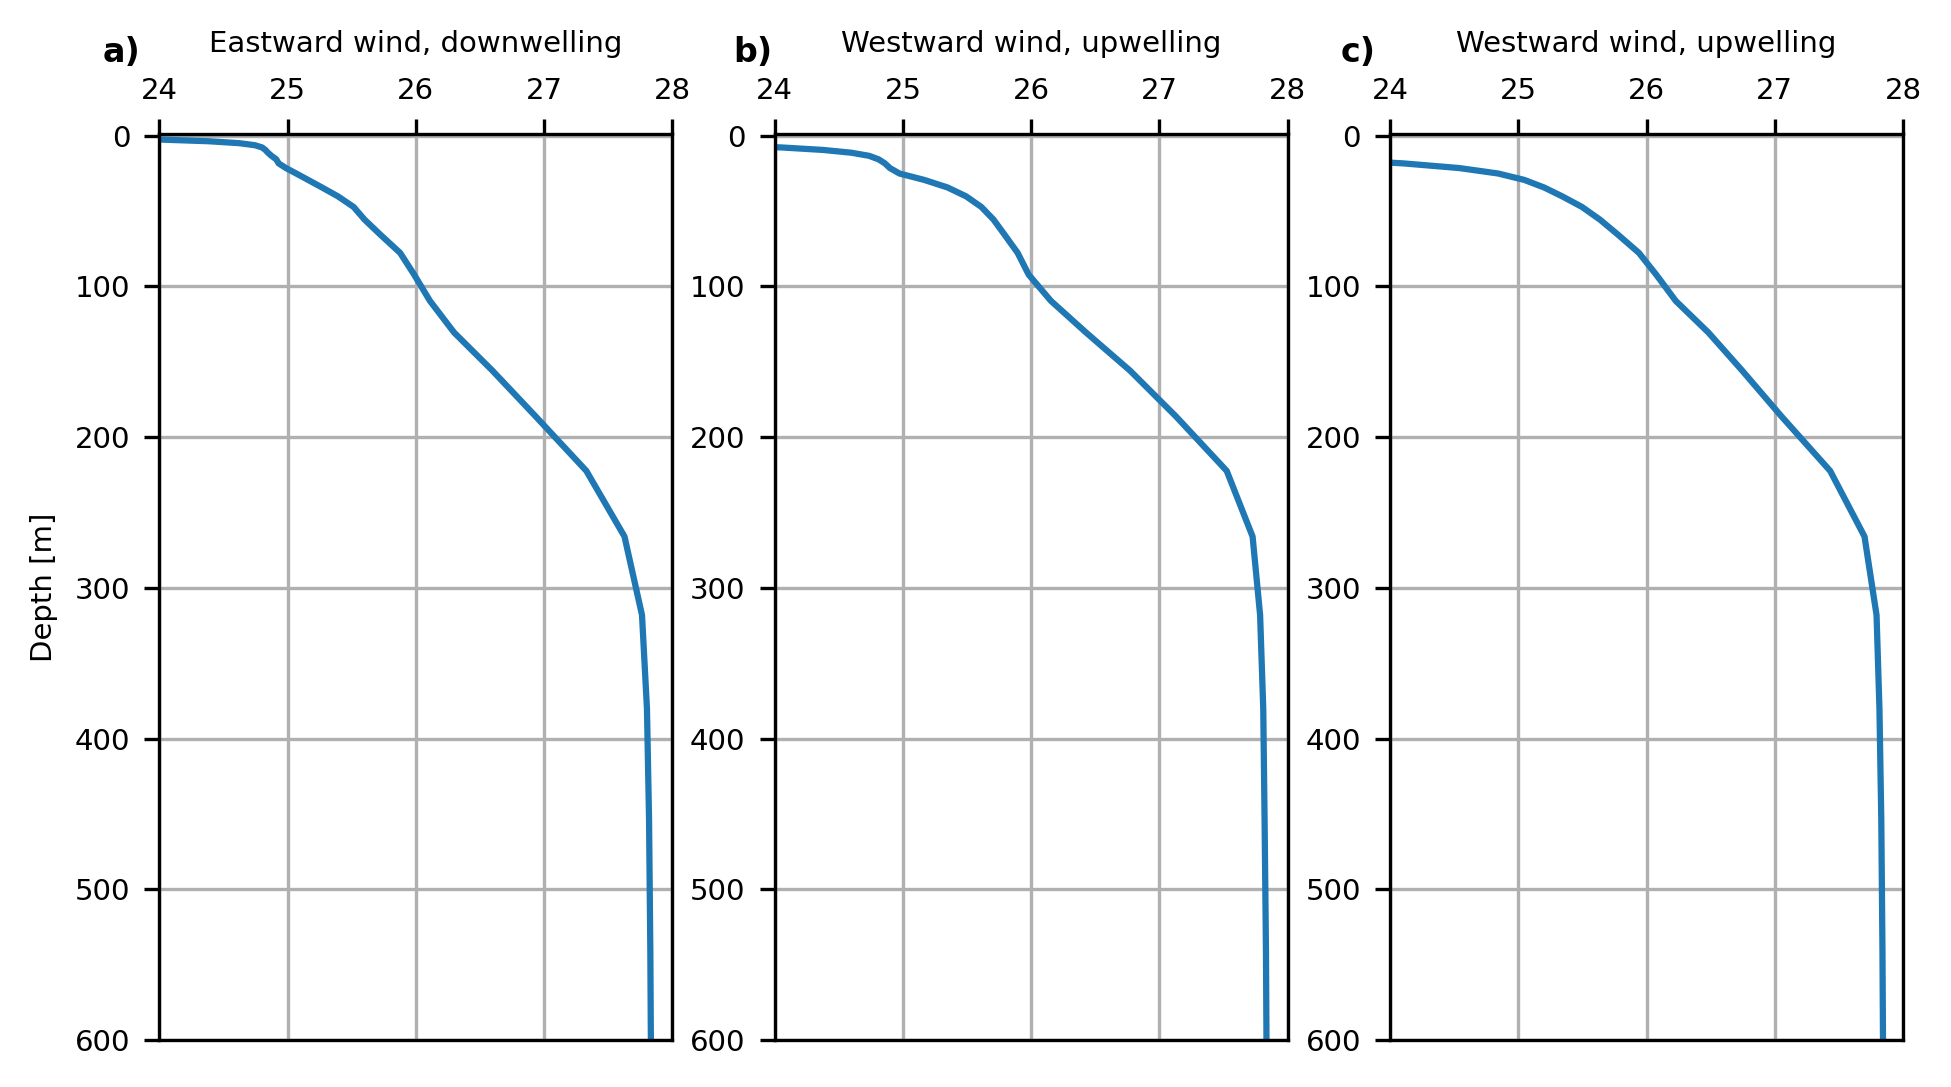

In [66]:
fig, ax = plt.subplots(1,3, figsize=(7.5,4), dpi=300)
# station coordinates:
istn = 650 #650
jstn = 301 #305

ax[0].set_ylabel('Depth [m]', fontsize=7)
for axis in ax.ravel():
    axis.invert_yaxis()
    axis.set_ylim(600,-1)
    axis.tick_params(axis='both', labelsize=7)
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top')
    axis.grid()

ax[0].plot(density[1,:,istn,jstn], depth)
ax[1].plot(density[11,:,istn,jstn], depth)
ax[2].plot(density[32,:,istn,jstn], depth)

# Labels:
ax[0].set_title('Eastward wind, downwelling', fontsize=7)
ax[0].set_xlim(24,28)
ax[1].set_title('Westward wind, upwelling', fontsize=7)
ax[1].set_xlim(24,28)
ax[2].set_title('Westward wind, upwelling', fontsize=7)
ax[2].set_xlim(24,28)
fig.text(0.10, 0.94, 'a)', fontsize=8, weight='bold');
fig.text(0.38, 0.94, 'b)', fontsize=8, weight='bold');
fig.text(0.65, 0.94, 'c)', fontsize=8, weight='bold');

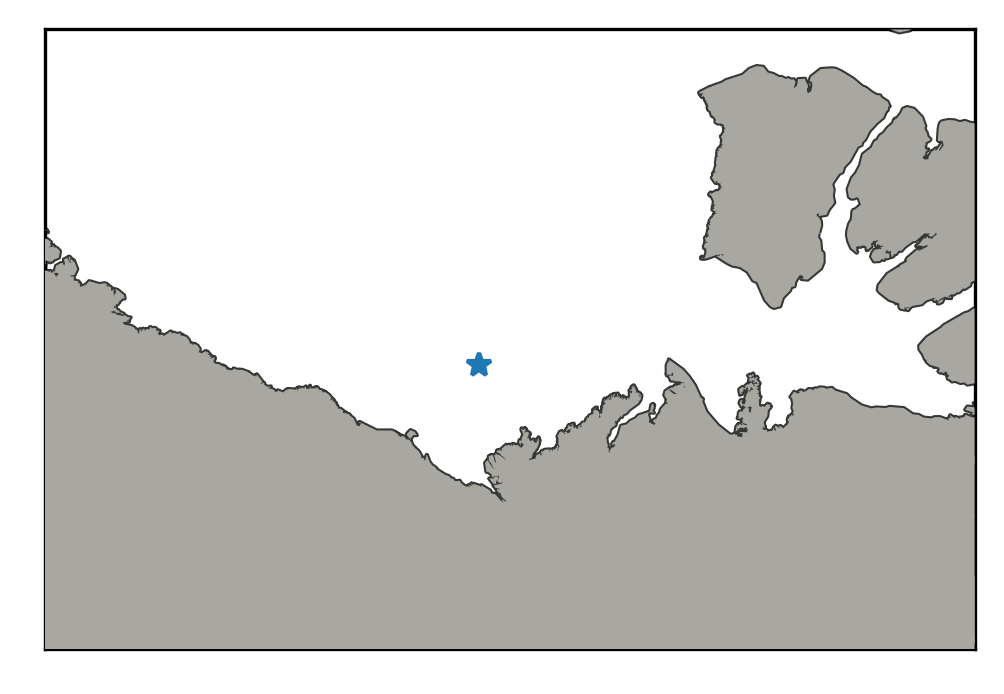

In [79]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=300)
proj2 = Basemap(projection='stere',lat_0 = 71, lon_0 = -135, resolution='i', width=1.5e6, height=1.0e6, ax=ax)
    
x_land, y_land = proj2(lon_ANHA12, lat_ANHA12)
istn = 650+imin
jstn = 301+jmin
proj2.drawcoastlines(color='#373736', linewidth=1.0)
proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
proj2.plot(x_land[istn,jstn], y_land[istn,jstn], '*', zorder=5)

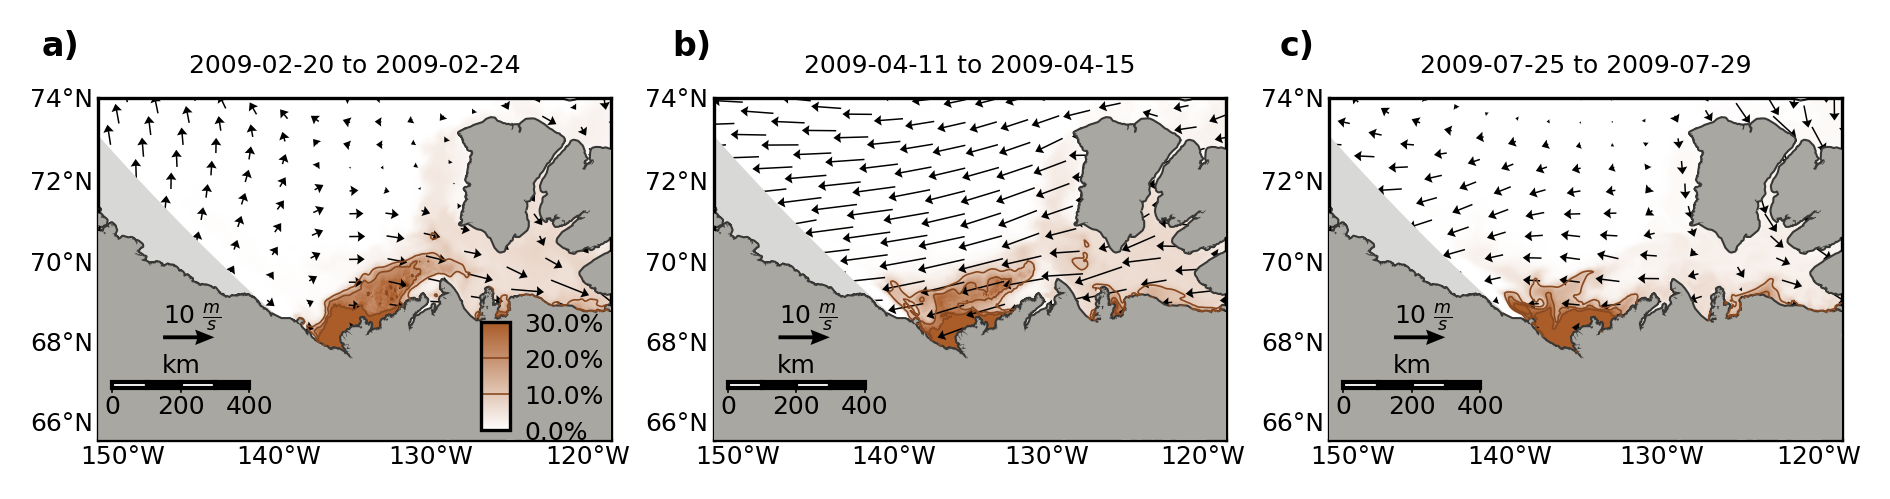

In [19]:
fig, ax = plt.subplots(1,3, figsize=(7.5,4), dpi=300)

time1 = 1
lw1, CS1, cont, QV1 = plot_5d_mackenzie(ax[0], continental_contribution_20093[time1,:,:], \
                        time1, files_ref_20093, overlap_dates_20093, overlap_uwind_20093, \
                        overlap_vwind_20093, wind=True, set_lw=True)

time2 = 11
lw2, CS2, cont, QV2 = plot_5d_mackenzie(ax[1], continental_contribution_20093[time2,:,:], \
                        time2, files_ref_20093, overlap_dates_20093, overlap_uwind_20093, \
                        overlap_vwind_20093, wind=True, lw=lw1)

time3 = 32
lw3, CS3, cont, QV3 = plot_5d_mackenzie(ax[2], continental_contribution_20093[time3,:,:], \
                        time3, files_ref_20093, overlap_dates_20093, overlap_uwind_20093, \
                        overlap_vwind_20093, wind=True, lw=lw2)
        
fig.text(0.10, 0.68, 'a)', fontsize=8, weight='bold');
fig.text(0.38, 0.68, 'b)', fontsize=8, weight='bold');
fig.text(0.65, 0.68, 'c)', fontsize=8, weight='bold');

cbaxes1 = fig.add_axes([0.295, 0.368, 0.013, 0.09])  
CBar1   = plt.colorbar(CS1, ax=ax, cax=cbaxes1, ticks=[0,10,20,30]) 
CBar1.add_lines(cont)
CBar1.ax.tick_params(axis='y', length=0, labelsize=6)
CBar1.ax.zorder = 7
CBar1.ax.set_yticklabels([f'{i:.1f}%' for i in CBar1.get_ticks()]);

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R2-Mackenzie.png', bbox_inches='tight', dpi=300)